DEVICE:  cpu
LEN 5


Testing: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]

c_set6_2_512_14_1.jpg
c_set5_2_512_16_9.jpg
c2_nr33_set4_9_512_9_18.jpg
c2_nr33_set4_0_512_5_3.jpg
c_set6_0_512_10_1.jpg


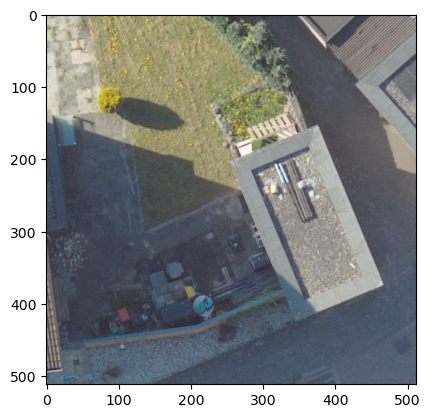

In [3]:
# %%
import os
import sys
sys.path.append('/home/sfonseka/dev/SRST/srst-dataloader/models')  # Adds the parent directory to the system path
sys.path.append('/home/sfonseka/dev/SRST/srst-dataloader/utils')  # Adds the parent directory to the system path

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os, cv2
import numpy as np
from PIL import Image
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from torchmetrics.classification import BinaryJaccardIndex as IoU, BinaryAccuracy

import dataloader as dl


THRESHOLD = 0.5

MODELS_LIST = [
    {
        'CLASS_NAME': 'asphalt',
        'BEST_MODEL': '/home/sfonseka/dev/SRST/srst-dataloader/experiments/UNET/asphalt/preliminary/runs/UNET_binary_grayscale_asphalt_1704597437.863613/models/best_model_UNET_binary_grayscale_asphalt_1704597437.863613.pt'
    }
]

import csv

test_results = []

def test_model(model, test_loader, device, class_name, model_path):
    model.eval()

    # Open CSV file for writing
    with open('test_metrics.csv', 'w', newline='') as csvfile:
        fieldnames = ['image_filename', 'test_iou', 'test_accuracy', 'class_name', 'model_path']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write header
        writer.writeheader()

        progress_bar = tqdm(test_loader, desc='Testing', leave=False)
        with torch.no_grad():
            for batch_index, (test_images, test_masks, __paths) in enumerate(progress_bar):
                test_images, test_masks = test_images.to(device), test_masks.to(device)

                for i in range(test_images.size(0)):
                    image = test_images[i].unsqueeze(0)
                    mask = test_masks[i].unsqueeze(0)
                    # print file name
                    image_filename = os.path.basename(__paths[i])
                    print(image_filename)

                    # Plot the image and mask
                    img_np = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
                    
                    output = model(image)
                    output_sigmoid = torch.sigmoid(output)

                    # Convert the output to a binary mask
                    test_pred = (output_sigmoid > THRESHOLD).int()  # Adjust THRESHOLD as needed, e.g., 0.5

                    metric_test_iou = IoU().to(device)  # Initialize IoU for binary classification (background, asphalt)
                    metric_test_accuracy = BinaryAccuracy().to(device)  # Initialize accuracy metric for binary classification

                    metric_test_iou.update(test_pred, mask)
                    metric_test_accuracy.update(test_pred, mask)

                    score_test_iou = metric_test_iou.compute()  # Compute final IoU score
                    score_test_accuracy = metric_test_accuracy.compute()  # Compute final accuracy score

                    # Write metrics to CSV file
                    writer.writerow({'image_filename': image_filename, 'test_iou': score_test_iou.item(), 'test_accuracy': score_test_accuracy.item(), 'class_name': class_name, 'model_path': model_path})

                    # Append results to list
                    test_results.append({
                        'image_filename': image_filename, 
                        'test_iou': score_test_iou.item(), 
                        'test_accuracy': score_test_accuracy.item(), 
                        'class_name': class_name, 
                        'model_path': model_path,
                        'output': output,
                        'mask': mask,
                        'image_np': img_np,   
                    })
           



from UNET import UNetBaseline
model = UNetBaseline(out_classes=1)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE: ', DEVICE)

for item in MODELS_LIST:
    CLASS_NAME = item['CLASS_NAME']
    BEST_MODEL = item['BEST_MODEL']

    IMG_DIR = f'/projects/0/gusr51794/srst_scratch_drive/binary_training/images/512/{CLASS_NAME}'
    TEST_DIR = f'/projects/0/gusr51794/srst_scratch_drive/binary_training/test/512/{CLASS_NAME}'


    state_dict = torch.load(BEST_MODEL, map_location=torch.device('cpu'))


    # Load the state dict into the model
    model.load_state_dict(state_dict)
    model.eval()  # Set the model to evaluation mode

    test_dataloader = dl.SRST_DataloaderGray(mask_dir=TEST_DIR, image_dir=IMG_DIR, mask_count=5)
    test_dataset = test_dataloader.dataset

    test_model(model, test_dataloader.data_loader, DEVICE, class_name=CLASS_NAME, model_path=BEST_MODEL)

In [4]:
# Load the results from pickle
import pickle
with open('test_results.pkl', 'rb') as f:
     test_results = pickle.load(f)


c_set6_2_512_14_1.jpg 0.10833445191383362 0.8988685607910156
output tensor([[[[0.0551, 0.0707, 0.1038,  ..., 0.2560, 0.1576, 0.1125],
          [0.0530, 0.0390, 0.0583,  ..., 0.2277, 0.1329, 0.1541],
          [0.0898, 0.0626, 0.0723,  ..., 0.2685, 0.2194, 0.2522],
          ...,
          [0.0886, 0.0609, 0.0666,  ..., 0.0662, 0.0649, 0.1201],
          [0.0551, 0.0366, 0.0508,  ..., 0.0516, 0.0395, 0.0715],
          [0.0534, 0.0619, 0.0824,  ..., 0.0856, 0.0638, 0.0633]]]])
output min tensor(0.0003)
output max tensor(0.5933)


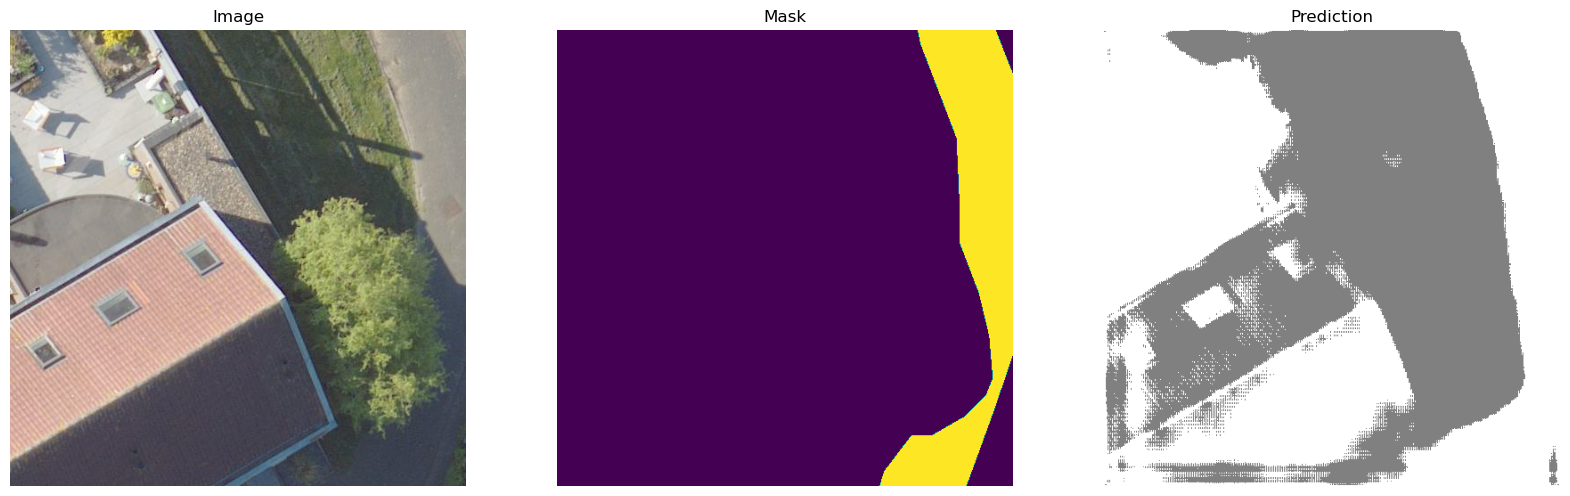

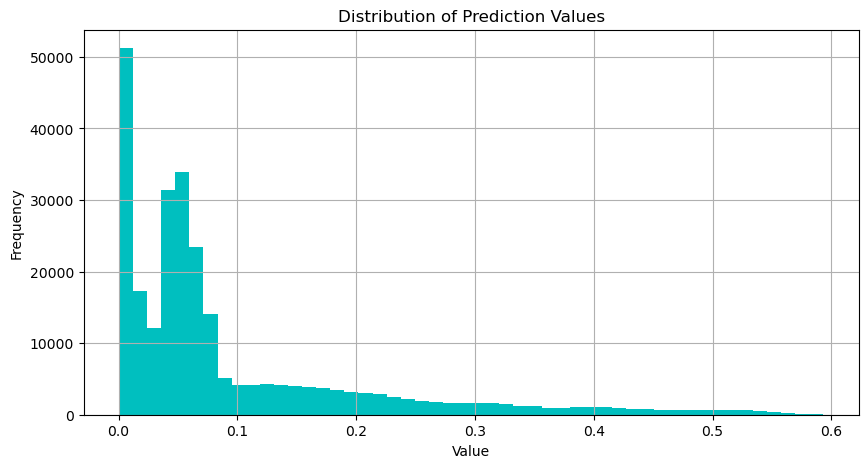

In [28]:
for item in test_results[:1]:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])



    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)



    pred = (output_sigmoid < threshold).int().squeeze(0).squeeze(0).cpu().numpy()

    plt.imshow(pred, alpha=0.5, cmap='binary')
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()